In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math

warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from lightgbm import LGBMRegressor
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Reshape, Dropout, LSTM, RepeatVector, TimeDistributed

In [300]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
sample_sub = pd.read_excel("Sample_Submission.xlsx")

In [301]:
train.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2/3/2017,291.0
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,7/1/2015,897.0
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,1/12/2019,792.0
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,12/12/2014,837.0
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,12/12/2013,470.0


In [302]:
print("Shape of train data : ",train.shape)

print("No. of Unique Product IDs : ",train.Product.nunique())
print("No. of Unique Product Bands : ",train.Product_Brand.nunique())
print("No. of Unique Item Categories : ",train.Item_Category.nunique())
print("No. of Unique Subcategory_1 : ",train.Subcategory_1.nunique())
print("No. of Unique Subcategory_2 : ",train.Subcategory_2.nunique())

Shape of train data :  (2452, 8)
No. of Unique Product IDs :  2452
No. of Unique Product Bands :  1010
No. of Unique Item Categories :  75
No. of Unique Subcategory_1 :  130
No. of Unique Subcategory_2 :  336


In [303]:
df = pd.concat([train,test]).reset_index(drop=True)

In [304]:
df.isnull().sum()

Product             0
Product_Brand       0
Item_Category       0
Subcategory_1       0
Subcategory_2       0
Item_Rating         0
Date                0
Selling_Price    1051
dtype: int64

In [305]:
le = LabelEncoder()
df['Product_Brands_Label'] = le.fit_transform(df['Product_Brand'])
df['Item_Category_Label'] = le.fit_transform(df['Item_Category'])
df['Subcategory_1_Label'] = le.fit_transform(df['Subcategory_1'])
df['Subcategory_2_Label'] = le.fit_transform(df['Subcategory_2'])

In [306]:
dates = pd.to_datetime(df['Date'])
df['day'] = dates.dt.day
df['month'] = dates.dt.month
df['year'] = dates.dt.year

In [307]:
df['Date'] = pd.to_datetime(df["Date"], format = "%d/%m/%Y", errors='coerce')

In [308]:
basicCols = df.columns

In [309]:
df.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price,Product_Brands_Label,Item_Category_Label,Subcategory_1_Label,Subcategory_2_Label,day,month,year
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2017-03-02,291.0,1130,9,11,159,3,2,2017
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,2015-01-07,897.0,877,17,139,387,1,7,2015
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,2019-12-01,792.0,369,38,119,118,12,1,2019
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,2014-12-12,837.0,877,12,40,155,12,12,2014
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,2013-12-12,470.0,877,17,86,344,12,12,2013


# EDA

In [310]:
df.groupby('Item_Category_Label')['Subcategory_1_Label'].count().head()

Item_Category_Label
0    1
1    1
2    1
3    1
4    1
Name: Subcategory_1_Label, dtype: int64

In [311]:
df.groupby('Subcategory_1_Label')['Subcategory_2_Label'].count().head()

Subcategory_1_Label
0      4
1     22
2    245
3      9
4      1
Name: Subcategory_2_Label, dtype: int64

In [312]:
df.groupby('Item_Category_Label')['Product_Brands_Label'].count().head()

Item_Category_Label
0    1
1    1
2    1
3    1
4    1
Name: Product_Brands_Label, dtype: int64

In [313]:
df.sort_values(by='Date').groupby('Product_Brands_Label')['Date'].diff(1).sort_index().head()

0        NaT
1     0 days
2   365 days
3     0 days
4     0 days
Name: Date, dtype: timedelta64[ns]

In [314]:
df.groupby(['year'])['Product_Brands_Label'].count().head()

year
2012    207
2013    398
2014    468
2015    442
2016    416
Name: Product_Brands_Label, dtype: int64

In [315]:
ranges = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
df.groupby(pd.cut(df.Item_Rating, ranges))['Item_Rating'].count()

Item_Rating
(0.0, 0.5]      0
(0.5, 1.0]     65
(1.0, 1.5]    412
(1.5, 2.0]    424
(2.0, 2.5]    385
(2.5, 3.0]    405
(3.0, 3.5]    435
(3.5, 4.0]    457
(4.0, 4.5]    451
(4.5, 5.0]    469
Name: Item_Rating, dtype: int64

# Feature Engineering

In [316]:
df['No_of_SubC1_in_ItemC'] = df['Item_Category_Label'].apply(lambda x : df.groupby('Item_Category_Label')['Subcategory_1_Label'].count()[x])

In [317]:
df['No_of_SubC2_in_SubC1'] = df['Subcategory_1_Label'].apply(lambda x : df.groupby('Subcategory_1_Label')['Subcategory_2_Label'].count()[x])

In [318]:
df['No_of_ProdB_in_ItemC'] = df['Item_Category_Label'].apply(lambda x : df.groupby('Item_Category_Label')['Product_Brands_Label'].count()[x])

In [319]:
for c in ['Product_Brands_Label', 'Item_Category_Label', 'Subcategory_1_Label', 'Subcategory_2_Label']:
    temp = df.sort_values(by='Date').groupby(c)['Date'].diff(1).sort_index()
    df[f'next_sale_day_diff_{c}'] = temp.dt.days

In [320]:
for i in range(1, 3):
    df[[f'next{i}_Subcategory_1_Label', f'next{i}_Subcategory_2_Label']] = df.sort_values(by='Date').groupby('Item_Category_Label')[['Subcategory_1_Label', 'Subcategory_2_Label']].shift(-i).sort_index()

In [321]:
for i in range(1, 3):
    df[[f'next{i}_Subcategory_1_Label', f'next{i}_Subcategory_2_Label', f'next{i}_Product_Brands_Label']] = df.sort_values(by='Date').groupby('Item_Category_Label')[['Subcategory_1_Label', 'Subcategory_2_Label', 'Product_Brands_Label']].shift(-i).sort_index()

In [322]:
df['ProdB_ItemRatings_CumSum'] = df.sort_values(by='Date').groupby('Product_Brands_Label')['Item_Rating'].cumsum().shift(-1).sort_index()

In [323]:
grp = df.groupby(['Product_Brands_Label','Date']).agg({'Item_Rating': ['max', 'sum', 'mean', 'min'], 'Item_Category_Label': ['nunique','size'],
                              'Subcategory_1_Label': ['nunique','size'], 'Subcategory_2_Label': ['nunique','size']})
grp.columns = ['_'.join(c).strip('_') + '_Product_Brands_Label_and_Date' for c in grp.columns]
df = pd.merge(df, grp, how = 'left', on =['Product_Brands_Label','Date'])

In [324]:
grp = df.groupby('year').agg({'Item_Rating': ['max', 'sum', 'mean', 'min'], 'Product_Brands_Label': ['nunique' ,'size'], 'Item_Category_Label': ['nunique','size'],
                              'Subcategory_1_Label': ['nunique','size'], 'Subcategory_2_Label': ['nunique','size']})
grp.columns = ['_'.join(c).strip('_') + '_yearwise' for c in grp.columns]
df = pd.merge(df, grp, how = 'left', on ='year')

In [325]:
df['n_days_from_start'] = (df['Date'].dt.date - df['Date'].min().date()).dt.days
df['n_days_from_end'] = (df['Date'].max().date() - df['Date'].dt.date).dt.days

In [326]:
for c in tqdm(['Product_Brands_Label', 'Item_Category_Label', 'Subcategory_1_Label', 'Subcategory_2_Label']):
    df[f'next_sale_diff_{c}'] = df.sort_values(by='Date').groupby(c)['n_days_from_start'].apply(lambda x: x - x.shift(-1))
    df[f'prev_sale_diff_{c}'] = df.sort_values(by='Date').groupby(c)['n_days_from_start'].apply(lambda x: x - x.shift(1))

100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


# Random FE

In [179]:
for c in ['Product_Brands_Label', 'Item_Category_Label', 'Subcategory_1_Label', 'Subcategory_2_Label']:
    temp = df.sort_values(by='Date').groupby(c)['Date'].diff(1).sort_index()
    df[f'next_sale_day_diff_{c}'] = temp.dt.days

In [180]:
df[['Prev_Subcategory_1_Label_Item', 'Prev_Subcategory_2_Label_Item']] = df.sort_values(by='Date').groupby('Item_Category_Label')[['Subcategory_1_Label', 'Subcategory_2_Label']].shift(1).sort_index()
df[['Prev_Subcategory_1_Label_Brand', 'Prev_Subcategory_2_Label_Brand']] = df.sort_values(by='Date').groupby('Item_Category_Label')[['Subcategory_1_Label', 'Subcategory_2_Label']].shift(1).sort_index()

In [181]:
for i in range(1, 6):
    df[[f'next{i}_Subcategory_1_Label', f'next{i}_Subcategory_2_Label', f'next{i}_Product_Brands_Label']] = df.sort_values(by='Date').groupby('Item_Category_Label')[['Subcategory_1_Label', 'Subcategory_2_Label', 'Product_Brands_Label']].shift(-i).sort_index()

In [182]:
for i in range(1, 6):
    df[[f'next{i}_Subcategory_1_Label', f'next{i}_Subcategory_2_Label', f'next{i}_Item_Category_Label']] = df.sort_values(by='Date').groupby('Product_Brands_Label')[['Subcategory_1_Label', 'Subcategory_2_Label', 'Item_Category_Label']].shift(-i).sort_index()

In [183]:
for c in tqdm(['Product_Brands_Label', 'Item_Category_Label', 'Subcategory_1_Label', 'Subcategory_2_Label']):
    df[f'ItemRatings_cumsum_{c}'] = df.sort_values(by='Date').groupby(c)['Item_Rating'].cumsum().shift(-1).sort_index()

100%|██████████| 4/4 [00:00<00:00, 71.40it/s]


In [184]:
grp = df.groupby('year').agg({'Item_Rating': ['max', 'sum', 'mean', 'min'], 'Product_Brands_Label': ['nunique' ,'size'], 'Item_Category_Label': ['nunique','size'],
                              'Subcategory_1_Label': ['nunique','size'], 'Subcategory_2_Label': ['nunique','size']})
grp.columns = ['_'.join(c).strip('_') + '_yearwise' for c in grp.columns]
df = pd.merge(df, grp, how = 'left', on ='year')

In [185]:
grp = df.groupby(['Subcategory_1_Label','Date']).agg({'Item_Rating': ['max', 'sum', 'mean', 'min'], 'Product_Brands_Label': ['nunique' ,'size'], 'Item_Category_Label': ['nunique','size'],
                              'Subcategory_2_Label': ['nunique','size']})
grp.columns = ['_'.join(c).strip('_') + '_Subcategory_1_Label_and_Date' for c in grp.columns]
df = pd.merge(df, grp, how = 'left', on =['Subcategory_1_Label','Date'])

In [186]:
grp = df.groupby(['Subcategory_2_Label','Date']).agg({'Item_Rating': ['max', 'sum', 'mean', 'min'], 'Product_Brands_Label': ['nunique' ,'size'], 'Item_Category_Label': ['nunique','size'],
                              'Subcategory_1_Label': ['nunique','size']})
grp.columns = ['_'.join(c).strip('_') + '_Subcategory_2_Label_and_Date' for c in grp.columns]
df = pd.merge(df, grp, how = 'left', on =['Subcategory_2_Label','Date'])

In [187]:
grp = df.groupby(['Product_Brands_Label','Date']).agg({'Item_Rating': ['max', 'sum', 'mean', 'min'], 'Item_Category_Label': ['nunique','size'],
                              'Subcategory_1_Label': ['nunique','size'], 'Subcategory_2_Label': ['nunique','size']})
grp.columns = ['_'.join(c).strip('_') + '_Product_Brands_Label_and_Date' for c in grp.columns]
df = pd.merge(df, grp, how = 'left', on =['Product_Brands_Label','Date'])

In [188]:
grp = df.groupby(['Item_Category_Label','Date']).agg({'Item_Rating': ['max', 'sum', 'mean', 'min'], 'Item_Category_Label': ['nunique','size'],
                              'Subcategory_1_Label': ['nunique','size'], 'Subcategory_2_Label': ['nunique','size']})
grp.columns = ['_'.join(c).strip('_') + '_Item_Category_Label_and_Date' for c in grp.columns]
df = pd.merge(df, grp, how = 'left', on =['Item_Category_Label','Date'])

In [189]:
df[f'n_days_from_start'] = (df['Date'].dt.date - df['Date'].min().date()).dt.days
df[f'n_weeks_from_start'] = (df['Date'].dt.date - df['Date'].min().date()).dt.days//7
df[f'n_days_from_end'] = (df['Date'].max().date() - df['Date'].dt.date).dt.days
df[f'n_weeks_from_end'] = (df['Date'].max().date() - df['Date'].dt.date).dt.days//7
df[f'n_months_from_start'] = (df['Date'].dt.date - df['Date'].min().date()).dt.days//30
df[f'n_months_from_end'] = (df['Date'].max().date() - df['Date'].dt.date).dt.days//30

In [190]:
for c in tqdm(['Product_Brands_Label', 'Item_Category_Label', 'Subcategory_1_Label', 'Subcategory_2_Label']):
    df[f'next_sale_diff_{c}'] = df.sort_values(by='Date').groupby(c)['n_days_from_start'].apply(lambda x: x - x.shift(-1))
    df[f'prev_sale_diff_{c}'] = df.sort_values(by='Date').groupby(c)['n_days_from_start'].apply(lambda x: x - x.shift(1))

100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


In [191]:
for c in tqdm(['Product_Brands_Label', 'Item_Category_Label', 'Subcategory_1_Label', 'Subcategory_2_Label']):
    df[f'next_sale_diff_{c}'] = df.sort_values(by='Date').groupby(c)['n_days_from_start'].apply(lambda x: x - x.shift(-2))
    df[f'prev_sale_diff_{c}'] = df.sort_values(by='Date').groupby(c)['n_days_from_start'].apply(lambda x: x - x.shift(2))

100%|██████████| 4/4 [00:02<00:00,  1.37it/s]


In [192]:
df[f'n_days_from_start_fid'] = df.groupby('Product_Brands_Label')['Date'].apply(lambda x: (x - x.min()).dt.days)
df[f'n_days_from_end_fid'] = df.groupby('Product_Brands_Label')['Date'].apply(lambda x: (x.max() - x).dt.days)
df[f'n_days_from_end_lno'] = df.groupby('Item_Category_Label')['Date'].apply(lambda x: (x.max() - x).dt.days)
df[f'n_days_from_start_lno'] = df.groupby('Item_Category_Label')['Date'].apply(lambda x: (x-x.min()).dt.days)

In [193]:
df[f'n_days_from_start_fn'] = df.groupby('Subcategory_1_Label')['Date'].apply(lambda x: (x - x.min()).dt.days)
df[f'n_days_from_end_fn'] = df.groupby('Subcategory_1_Label')['Date'].apply(lambda x: (x.max() - x).dt.days)
df[f'n_days_from_start_geoloc'] = df.groupby('Subcategory_2_Label')['Date'].apply(lambda x: (x - x.min()).dt.days)
df[f'n_days_from_end_geoloc'] = df.groupby('Subcategory_2_Label')['Date'].apply(lambda x: (x.max() - x).dt.days)

# Data Ready

In [327]:
df.drop(['Product','Product_Brand','Item_Category','Subcategory_1','Subcategory_2','Date'],axis=1,inplace=True)
df.drop(['n_days_from_start','n_days_from_end'],axis=1,inplace=True)

In [329]:
featureCols = df.columns
featureCols = set(featureCols) - set(basicCols)
for col in tqdm(featureCols):
    df[f'is_{col}_null'] = df[col].apply(lambda x : 0 if math.isnan(x) else 1)

100%|██████████| 44/44 [00:00<00:00, 242.08it/s]


In [332]:
df.fillna(df.mean(),inplace=True)
print("No of null values : ",df.isnull().sum().sum())

No of null values :  0


In [333]:
X = df.loc[:train.shape[0]-1]
test = df.loc[train.shape[0]:]

y = X['Selling_Price']
X.drop('Selling_Price',axis=1,inplace=True)
test.drop('Selling_Price',axis=1,inplace=True)

In [334]:
print("Training Data Shape : ",X.shape)
print("Training Target Shape : ",y.shape)
print("Test Data Shape : ",test.shape)

Training Data Shape :  (2452, 96)
Training Target Shape :  (2452,)
Test Data Shape :  (1051, 96)


In [335]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Train Model

### CatBoost

In [230]:
# errcb2=[]
# y_pred_totcb2=[]
# fold=KFold(n_splits=6)
# epoch = 1
# for train_index, test_index in fold.split(X,y):
#     print("Epoch : ",epoch)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     model = CatBoostRegressor(n_estimators=3000,eval_metric='RMSE',
#                             learning_rate=0.01, random_seed= 42, 
#                             use_best_model=True )
#     model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], 
#            early_stopping_rounds=200,verbose=100)
#     preds=model.predict(X_test)
#     print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
#     errcb2.append(np.sqrt(mean_squared_error(y_test,preds)))
#     p2 = model.predict(test)
#     y_pred_totcb2.append(p2)
#     epoch += 1
# np.mean(errcb2)

In [199]:
# model = CatBoostRegressor(n_estimators=3000,eval_metric='RMSE',
#                         learning_rate=0.005, random_seed= 42, 
#                         use_best_model=True )
# model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val, y_val)], 
#        early_stopping_rounds=200,verbose=100)
# preds_val = model.predict(X_val)
# print("err: ",np.sqrt(mean_squared_error(y_val,preds_val)))

### LGBM

In [231]:
model = LGBMRegressor(learning_rate=0.03, colsample_bytree=0.8, reg_alpha=8, reg_lambda=9, max_depth=-1, n_estimators=3000, min_child_samples=15, num_leaves=127)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=100, early_stopping_rounds=200)
predictions_val_lgb = model.predict(X_val)
print(f"RMSE of the Model: {np.sqrt(mean_squared_error(y_val, predictions_val_lgb))}")

Training until validation scores don't improve for 200 rounds
[100]	training's l2: 9.23445e+06	valid_1's l2: 1.03168e+07
[200]	training's l2: 6.37889e+06	valid_1's l2: 7.81774e+06
[300]	training's l2: 5.06785e+06	valid_1's l2: 6.6363e+06
[400]	training's l2: 4.21175e+06	valid_1's l2: 5.81808e+06
[500]	training's l2: 3.57563e+06	valid_1's l2: 5.16544e+06
[600]	training's l2: 3.10117e+06	valid_1's l2: 4.72428e+06
[700]	training's l2: 2.69732e+06	valid_1's l2: 4.29619e+06
[800]	training's l2: 2.33515e+06	valid_1's l2: 3.90085e+06
[900]	training's l2: 2.00284e+06	valid_1's l2: 3.55809e+06
[1000]	training's l2: 1.72357e+06	valid_1's l2: 3.24911e+06
[1100]	training's l2: 1.48936e+06	valid_1's l2: 3.02516e+06
[1200]	training's l2: 1.29958e+06	valid_1's l2: 2.83304e+06
[1300]	training's l2: 1.14287e+06	valid_1's l2: 2.68497e+06
[1400]	training's l2: 1.02185e+06	valid_1's l2: 2.5619e+06
[1500]	training's l2: 918581	valid_1's l2: 2.45486e+06
[1600]	training's l2: 829480	valid_1's l2: 2.3624e+06


### CNN

In [343]:
model = Sequential()
model.add(Reshape((X_train.shape[1],1)))
model.add(Conv1D(filters = 32, kernel_size = 3,padding = 'Same',
             activation ='relu', input_shape = (X_train.shape[1],1)))
model.add(Conv1D(filters = 64, kernel_size = 3,padding = 'Same',
             activation ='relu'))
model.add(Flatten())
model.add(Dense (100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense (10, activation='relu'))
model.add(Dense (1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['msle'])

CNNModel = model.fit(np.array(X_train), np.array(y_train), epochs=45, 
                     batch_size=20, validation_data=(np.array(X_val),np.array(y_val)))

Train on 1839 samples, validate on 613 samples
Epoch 1/45
1839/1839 [==============================] - 1s 780us/sample - loss: 53050590.6651 - mean_squared_logarithmic_error: 2.7499 - val_loss: 39937046.3322 - val_mean_squared_logarithmic_error: 1.8974
Epoch 2/45
1839/1839 [==============================] - 1s 605us/sample - loss: 45745416.5519 - mean_squared_logarithmic_error: 2.7453 - val_loss: 31544054.9543 - val_mean_squared_logarithmic_error: 2.9116
Epoch 3/45
1839/1839 [==============================] - 1s 649us/sample - loss: 36206719.5704 - mean_squared_logarithmic_error: 4.8313 - val_loss: 26400037.4723 - val_mean_squared_logarithmic_error: 1.4609
Epoch 4/45
1839/1839 [==============================] - 1s 677us/sample - loss: 32045345.2603 - mean_squared_logarithmic_error: 3.6251 - val_loss: 26194065.9241 - val_mean_squared_logarithmic_error: 1.4309
Epoch 5/45
1839/1839 [==============================] - 1s 712us/sample - loss: 31108279.9173 - mean_squared_logarithmic_error: 3

1839/1839 [==============================] - 1s 622us/sample - loss: 18262008.8875 - mean_squared_logarithmic_error: 1.4000 - val_loss: 17944965.2953 - val_mean_squared_logarithmic_error: 1.6054
Epoch 41/45
1839/1839 [==============================] - 1s 636us/sample - loss: 17739192.0588 - mean_squared_logarithmic_error: 1.6296 - val_loss: 16736751.5814 - val_mean_squared_logarithmic_error: 1.1767
Epoch 42/45
1839/1839 [==============================] - 1s 635us/sample - loss: 17620212.1468 - mean_squared_logarithmic_error: 1.3444 - val_loss: 17137897.5734 - val_mean_squared_logarithmic_error: 1.4076
Epoch 43/45
1839/1839 [==============================] - 1s 631us/sample - loss: 17594309.8416 - mean_squared_logarithmic_error: 1.5937 - val_loss: 17847213.4604 - val_mean_squared_logarithmic_error: 2.5689
Epoch 44/45
1839/1839 [==============================] - 1s 623us/sample - loss: 18141813.6260 - mean_squared_logarithmic_error: 1.5977 - val_loss: 16549224.0982 - val_mean_squared_log

# Visualize Model

dict_keys(['loss', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_logarithmic_error'])


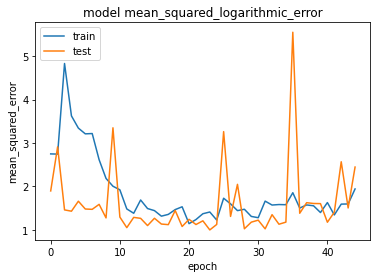

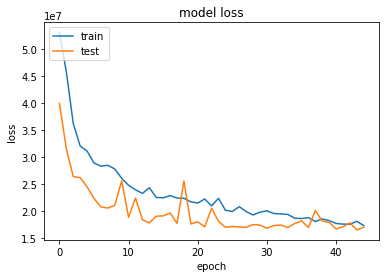

In [345]:
print(CNNModel.history.keys())

plt.plot(CNNModel.history['mean_squared_logarithmic_error'])
plt.plot(CNNModel.history['val_mean_squared_logarithmic_error'])
plt.title('model mean_squared_logarithmic_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(CNNModel.history['loss'])
plt.plot(CNNModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predict

In [346]:
preds = model.predict(test)

# Submit

In [347]:
sub = sample_sub.copy()
sub['Selling_Price'] = np.clip(preds,0,100000)
sub.to_excel("submission_CNN_2.xlsx",index=False)